In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
#import regionmask
import pandas as pd
from geopy.geocoders import Nominatim
from matplotlib.colors import SymLogNorm

import xesmf as xe
#from pykrige.ok import OrdinaryKriging
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import dask
import utils

In [2]:
#import data from:
### Gallagher, Kevin P. (2021), “China’s Global Energy Finance,” Global Development Policy Center, Boston University.
### Gallagher, Kevin P., Li, Zhongshu, Chen, Xu, Ma, Xinyue (2019), “China’s Global Power Database,” Global Development Policy Center, Boston University.

In [3]:
CGP_df = pd.read_excel('BU_data/CGP-Database_2020-1-2.xlsx')

In [4]:
CGP_df = CGP_df.loc[CGP_df['Technology'] == 'Coal']

In [5]:
#CGEF_df['Country'] = CGEF_df['Country'].str.lower()
CGP_df['Country'] = CGP_df['Country'].str.lower()

for idx in CGP_df.index:
    geolocator = Nominatim(timeout=10, user_agent = "myGeolocator")
    location = geolocator.geocode([CGP_df['State'].loc[idx],CGP_df['Country'].loc[idx]])
    CGP_df.loc[idx, 'lat'] = location.latitude + np.random.normal(0,.0001,1) #adding small random noise so that lats and lons don't repeat for plants in same county
    CGP_df.loc[idx, 'lon'] = location.longitude + np.random.normal(0,.0001,1) #adding small random noise so that lats and lons don't repeat for plants in same county
    CGP_df.loc[idx, 'location'] = location[0]

In [6]:
## https://pubs.acs.org/doi/abs/10.1021/es3003684 Table S1 
EF = np.exp(-3.64) #g/kg BC/coal

## https://www.nap.edu/read/9736/chapter/8 
HHF = 22.51 #GJ/t

#conversion factors
GJ_to_MwH = .28

Mw_to_MwH = 24 #daily

ton_to_kg = 0.001 #metric tons

MW_gpDay = Mw_to_MwH/GJ_to_MwH/HHF*ton_to_kg*EF #g/day


In [7]:
CGP_df = CGP_df.loc[CGP_df['Region'] == 'Southeast Asia']

In [8]:
CGP_df.loc[:,'BC (g/day)'] = CGP_df['Capacity (MW)']*MW_gpDay

In [9]:
CGP_df.columns = CGP_df.columns.str.replace(' ', '_')

In [10]:
CGP_df.loc[CGP_df.Year_of_Commission == 'Pending', 'Year_of_Commission'] = 9999

# Create Scenarios

In [11]:
## Add time dimension
length_simulation = 30*365

time_array = np.arange(0, length_simulation)

In [12]:
CGP_op = CGP_df.loc[CGP_df['Project_Status'] == 'In Operation']

In [13]:
def early_retirement_by_year(shutdown_years, df):
    ''' df must have a variable 'Year_of_Comission' describing when the plant was comissioned, and 'BC_(g/day)' for BC emissions in g/day'''
    #shutdown_years = 10
    min_comission_yr = df['Year_of_Commission'].min()
    shutdown_days = shutdown_years*365

    E = np.zeros(len(time_array))
    for year_comis in np.arange(min_comission_yr, df['Year_of_Commission'].max()):
        #print(year_comis)
        #print(CGP_op.loc[CGP_op.Year_of_Commission == year_comis]['BC_(g/day)'].sum())
        test_array = np.where((time_array < (year_comis-min_comission_yr)*365 + shutdown_days) & (time_array >= (year_comis-min_comission_yr)*365), True, False)
        #plt.plot(test_array)
        E += test_array* df.loc[df.Year_of_Commission == year_comis]['BC_(g/day)'].sum()
        #plt.plot(E)
    return(E)

In [14]:
E = {}
for year in np.arange(0,40):
    E[year] = early_retirement_by_year(20, CGP_op)

## Scenario 1: Commission Year

In [ ]:
### fix so that it is starting from the correct year (if they aren't operating, you may have them going too early)

In [17]:
E_comis = {}
for yr in np.arange(0,30):
    utils.shutdown_early_commission_year(yr, time_array, 2016, E_comis, CGP_df)

## Scenario 2: Lender

In [18]:
E_lender = {}
for yr in np.arange(0,30):
    utils.shutdown_by_lender(yr, time_array, 'CDB', E_lender, CGP_df)
for yr in np.arange(0,30):
    utils.shutdown_by_lender(yr, time_array, 'Ex-Im Bank', E_lender, CGP_df)
for yr in np.arange(0,30):
    utils.shutdown_by_lender(yr, time_array, 'CDB-Ex-Im Cofinancing', E_lender, CGP_df)

## Scenario 3: Country

In [19]:
E_country = {}
for yr in np.arange(0,30):
    for country in ['vietnam','cambodia','malaysia','indonesia','singapore']:
        utils.shutdown_by_country(yr, time_array, country, E_country, CGP_df)

## Plots of scenarios

Text(0.5, 0, 'Day')

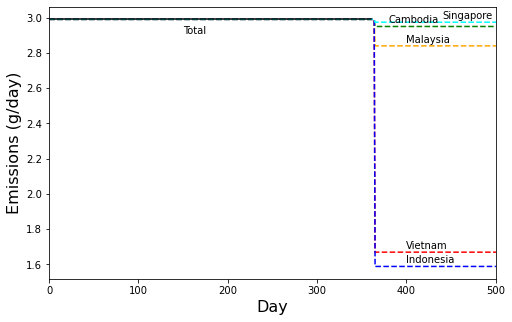

In [16]:
fig, ax = plt.subplots(figsize = [8,5])
for scen in E_country.keys():
    if '_1yrs' in scen:
        if 'vietnam' in scen:
            plt.plot(E_country[scen], c = 'red', linestyle = '--')
            ax.text(400, E_country[scen].min() + .02, 'Vietnam')
        if 'singapore' in scen:
            plt.plot(E_country[scen], c = 'cyan', linestyle = '--')
            ax.text(440, E_country[scen].min() + .02, 'Singapore')
        if 'malaysia' in scen:
            plt.plot(E_country[scen], c = 'orange', linestyle = '--')
            ax.text(400, E_country[scen].min() + .02, 'Malaysia')
        if 'indonesia' in scen:
            plt.plot(E_country[scen], c = 'blue', linestyle = '--')
            ax.text(400, E_country[scen].min() + .02, 'Indonesia')
        if 'cambodia' in scen:
            plt.plot(E_country[scen], c = 'green', linestyle = '--')
            ax.text(380, E_country[scen].min() + .02, 'Cambodia')
plt.axhline(y=E_country[scen].max(), xmin = 0, xmax = .72, color='k', linestyle='-')
ax.text(150, E_country[scen].max() - .08, 'Total')
plt.xlim(0,500)
plt.ylabel('Emissions (g/day)', fontsize = 16)
plt.xlabel('Day', fontsize = 16)

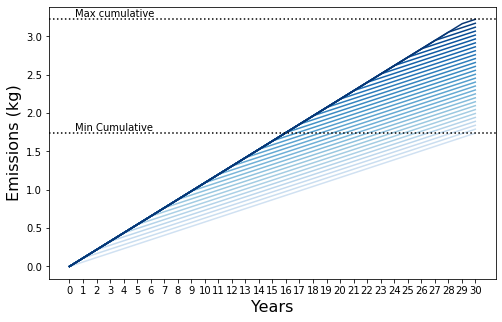

In [17]:
from matplotlib.pyplot import cm
color = iter(cm.Blues(np.linspace(0.2, 1, 31)))

fig, ax = plt.subplots(figsize = [8,5])
for scen in E_country.keys():
    
    if 'indonesia' in scen:
        c = next(color)
        plt.plot(E_country[scen].cumsum()/1e4, color = c)
plt.axhline(y=E_country['indonesia_0yrs'].sum()/1e4, xmin = 0, xmax = 1, color='k', linestyle=':')
ax.text(150, E_country['indonesia_0yrs'].sum()/1e4+.03, 'Min Cumulative')

plt.axhline(y=E_country['indonesia_29yrs'].sum()/1e4, xmin = 0, xmax = 1, color='k', linestyle=':')
ax.text(150, E_country['indonesia_29yrs'].sum()/1e4 +.03, 'Max cumulative')

plt.xlabel('Years',fontsize = 16)
plt.ylabel('Emissions (kg)',fontsize = 16)
ax.set_xticks(np.linspace(0, 10950, 31))
# Set the tick labels
ax.set_xticklabels(np.arange(0,31));
#plt.xlim(0,500)

# Convolve with G

In [15]:
#import the green's function and set our time step
G = xr.open_dataarray('Outputs/G_SEA_BC_total.nc4')
dt = 1 #day

In [16]:
#a floating pt is a byte * 8e-9 to get gbytes
np.product(G.shape)*8e-9

27.769651200000002

In [17]:
G_lev0 = G.isel(lev = 0, tp = 0).sel(s = slice(0,24)).compute()

In [18]:
np.product(G_lev0.shape)*8e-9

0.00995328

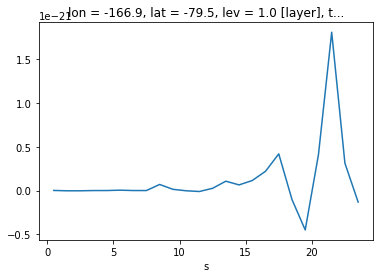

In [19]:
G_lev0.isel(lat = 10, lon = 10).plot()

## Tests

In [95]:
test_runs = ['indonesia_10yrs', 'singapore_10yrs', 
           'indonesia_20yrs', 'singapore_20yrs']

In [96]:
%%time
### global average

C_country = {}
for nm in test_runs:
    C_country[nm] = utils.convolve_single_lev(G_lev0, E_country[nm])

CPU times: user 2min 10s, sys: 4.09 s, total: 2min 14s
Wall time: 2min 15s


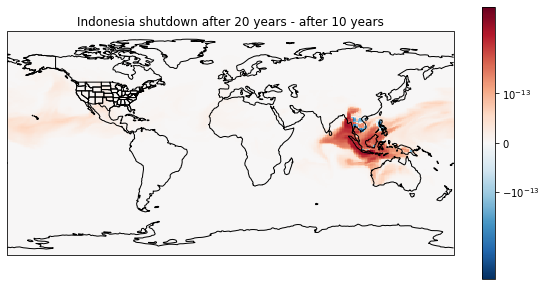

In [123]:
fig, ax = plt.subplots(figsize = [10,5], subplot_kw={'projection':ccrs.PlateCarree()})
(C_country['indonesia_20yrs'].sum(dim = 's') - C_country['indonesia_10yrs'].sum(dim = 's')).plot(transform = ccrs.PlateCarree(), norm = SymLogNorm(linthresh = 1e-13))
ax.coastlines()
ax.add_feature(cfeat.STATES)
plt.title('Indonesia shutdown after 20 years - after 10 years');

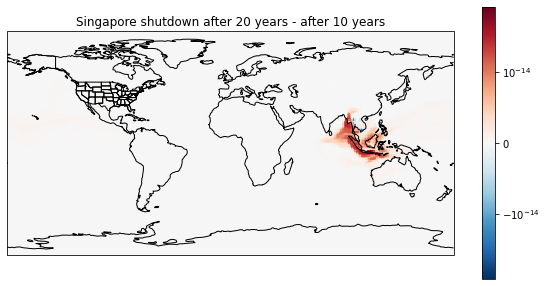

In [125]:
fig, ax = plt.subplots(figsize = [10,5], subplot_kw={'projection':ccrs.PlateCarree()})
(C_country['singapore_20yrs'].sum(dim = 's') - C_country['singapore_10yrs'].sum(dim = 's')).plot(transform = ccrs.PlateCarree(), norm = SymLogNorm(linthresh = 1e-14))
ax.coastlines()
ax.add_feature(cfeat.STATES)
plt.title('Singapore shutdown after 20 years - after 10 years');

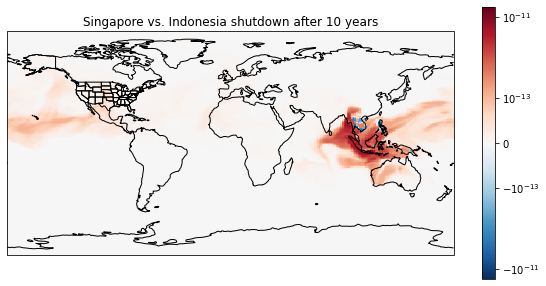

In [126]:
fig, ax = plt.subplots(figsize = [10,5], subplot_kw={'projection':ccrs.PlateCarree()})
(C_country['singapore_10yrs'].sum(dim = 's') - C_country['indonesia_10yrs'].sum(dim = 's')).plot(transform = ccrs.PlateCarree(), norm = SymLogNorm(linthresh = 1e-13))
ax.coastlines()
ax.add_feature(cfeat.STATES)
plt.title('Singapore vs. Indonesia shutdown after 10 years');